In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
DATA_DIR = Path("../data/raw")

# Find all Excel files in data/raw
FILES = sorted(DATA_DIR.glob("*.xlsx"))

POLLUTANTS = ["PM10", "PM2.5", "O3", "NO2", "CO", "SO2"]

if not FILES:
    raise RuntimeError("No Excel files found in data/raw.")

frames = []

for f in FILES:
    try:
        xls = pd.ExcelFile(f)
    except Exception:
        continue

    for sheet_name in xls.sheet_names:
        try:
            df = pd.read_excel(f, sheet_name=sheet_name)
        except Exception:
            continue

        # Try to find a datetime column; otherwise use the first column
        date_candidates = ["fecha y hora", "fecha", "date", "datetime", "date - time", "unnamed: 0"]
        dt_col = None
        for c in df.columns:
            if str(c).strip().lower() in date_candidates:
                dt_col = c
                break
        if dt_col is None and len(df.columns) > 0:
            dt_col = df.columns[0]
        if dt_col is None:
            continue

        # Clean datetime and set as index
        df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")
        df = df.dropna(subset=[dt_col]).set_index(dt_col).sort_index()

        # Convert to numeric where possible
        df_num = df.apply(pd.to_numeric, errors="coerce")

        # Simple averages per pollutant across any matching columns
        simple = {}
        for p in POLLUTANTS:
            pcols = [c for c in df_num.columns if p in str(c)]
            if pcols:
                simple[p] = df_num[pcols].mean(axis=1)

        if simple:
            frames.append(pd.DataFrame(simple))

if not frames:
    raise RuntimeError("No PM2.5/PM10 columns found in any file. Check data/raw and sheet contents.")

# Combine all pieces and average duplicate timestamps
hourly = pd.concat(frames, axis=0).groupby(level=0).mean().sort_index()

# Quick look at the data
print(hourly.head())


Yearly averages (PM2.5, PM10):
            PM10      PM2.5         O3        NO2        CO        SO2
2020  52.451286  20.430160  26.539421  20.175023  1.459463  12.510011
2021  59.769576  20.823537  25.969899  13.007391  1.472736   5.608241
2022  60.016674  20.531143  25.787100  14.832529  1.436275   5.323490
2023  61.743803  20.621220  26.594806  15.667161  1.154509   4.024741
2024  62.739340  20.721068  27.680785  14.785501  1.477232   4.195925


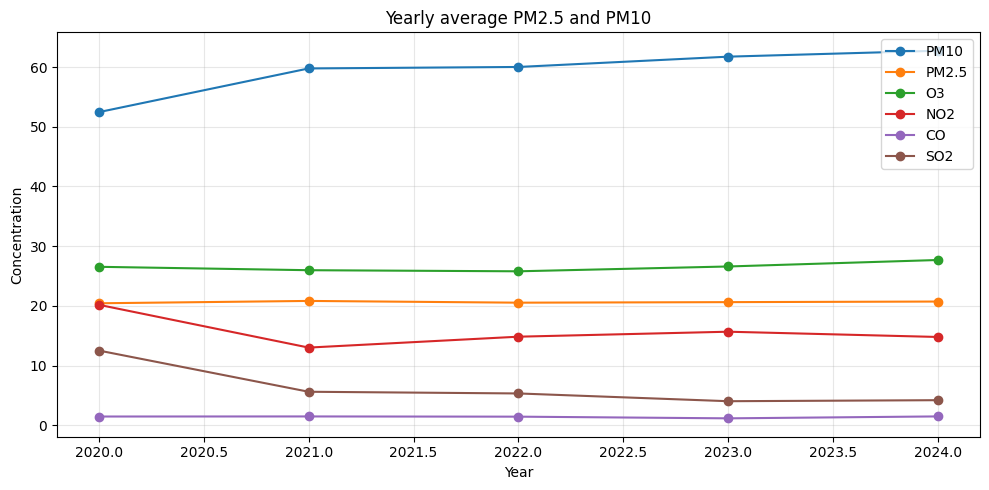

In [23]:
# Aggregate
monthly = hourly.resample("MS").mean()
yearly = hourly.resample("YE").mean()
yearly.index = yearly.index.year

print("\nYearly averages (PM2.5, PM10):\n", yearly)

# Plot yearly trends
plt.figure(figsize=(10, 5))
for col in yearly.columns:
    plt.plot(yearly.index, yearly[col], marker="o", label=col)

plt.title("Yearly average PM2.5 and PM10")
plt.xlabel("Year")
plt.ylabel("Concentration")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
